**<h1>ANALISIS DAN CLUSTERING MAKNA AYAT AL-QUR’AN DENGAN MINI SEARCH ENGINE BM25<h1/>**
1. Dheaz Kelvin Harahap (162012233011)
2. Daffa Pratama Yudhistira (162012233065)
3. Azka Muhammad Pinandito (162012233066)
4. Muhammad Rizky Ramadhan (162012233086)
5. Reynaldo Arya Budi T (162012233087)

👾👾👾👾👾👾👾👾👾👾👾

# **<h1>Preparation<h1/>**

In [1]:
#@title 0. Check GPU
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [2]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Install Depencies
!pip install Sastrawi
!pip install Arabic-Stopwords
!pip install qalsadi
!pip install gensim spacy nltk
!pip install googletrans==4.0.0-rc1
!pip install fuzzywuzzy
!pip install rank_bm25

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

import pyarabic.araby as araby
from nltk.corpus import stopwords
import arabicstopwords.arabicstopwords as stp
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import ArabicStemmer
import qalsadi.lemmatizer

from nltk.stem.snowball import ArabicStemmer
import pyarabic.araby as araby
import re


st = ArabicStemmer()
lemmer = qalsadi.lemmatizer.Lemmatizer()

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)
sns.set()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 15.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.6/256.6 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.6/332.6 kB 33.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━

In [4]:
#@title Load the data
df = pd.read_csv("/content/drive/MyDrive/Arabic-Original.csv", header=None, names=['text'])

In [5]:
#@title Manipulate dataframe to include surah and ayah columns
df = df['text'].str.split('|', expand=True)

# Convert 'surah_num' and 'ayah_num' columns to integer type
df.columns = ['surah_num', 'ayah_num', 'ayah_txt']
df['surah_num'] = df['surah_num'].astype('int')
df['ayah_num'] = df['ayah_num'].astype('int')

# Print the updated dataframe
print(df.head())

   surah_num  ayah_num                                  ayah_txt
0          1         1    بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ
1          1         2     الْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ
2          1         3                   الرَّحْمَٰنِ الرَّحِيمِ
3          1         4                   مَالِكِ يَوْمِ الدِّينِ
4          1         5  إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ


In [6]:
#@title Preprocessing Arabic Text

import nltk
nltk.download('stopwords')

# Preprocessing
def preprocess_text(text):
    # Normalize characters
    text = araby.strip_tashkeel(text) #Menghapus tashkeel (tanda-tanda pengucapan) dari teks
    text = araby.normalize_hamza(text) #Normalisasi karakter hamzah ke dalam bentuk yang konsisten
    text = araby.normalize_ligature(text) #Normalisasi ligature (huruf yang saling berhubungan) ke dalam bentuk yang konsisten
    text = araby.strip_tatweel(text) #Menghapus tatweel (pemisah kata panjang) dari teks

    # Remove non-Arabic characters
    text = re.sub(r'[^؀-ۿ\s]', '', text)

    return text

df['preprocessed_text'] = df['ayah_txt'].apply(preprocess_text)

# Stopword removal
stopwords_list = stopwords.words('arabic')
# stopwords_list += stopwords.words('english')  # Add additional stopwords if needed

df['clean_text'] = df['preprocessed_text'].apply(lambda text: '             '.join([word for word in text.split() if word not in stopwords_list]))

# Print the updated dataframe
(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,surah_num,ayah_num,ayah_txt,preprocessed_text,clean_text
0,1,1,بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ,بسم الله الرحمٰن الرحيم,بسم الله الرحمٰن الرحيم
1,1,2,الْحَمْدُ لِلَّهِ رَبِّ الْعَالَمِينَ,الحمد لله رب العالمين,الحمد لله رب العالمين
2,1,3,الرَّحْمَٰنِ الرَّحِيمِ,الرحمٰن الرحيم,الرحمٰن الرحيم
3,1,4,مَالِكِ يَوْمِ الدِّينِ,مالك يوم الدين,مالك يوم الدين
4,1,5,إِيَّاكَ نَعْبُدُ وَإِيَّاكَ نَسْتَعِينُ,ءياك نعبد وءياك نستعين,ءياك نعبد وءياك نستعين


In [7]:
#@title Import dataset from this API to take surah name (latin text)
import requests

def get_surah_names():
    surah_names = []  # list untuk memuat nama surah

    url = "https://api.alquran.cloud/v1/quran/id.indonesian"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        surahs = data["data"]["surahs"]

        for surah in surahs:
            surah_names.append(surah["englishName"])

    return surah_names

surah_names = get_surah_names()
(surah_names)

['Al-Faatiha',
 'Al-Baqara',
 'Aal-i-Imraan',
 'An-Nisaa',
 'Al-Maaida',
 "Al-An'aam",
 "Al-A'raaf",
 'Al-Anfaal',
 'At-Tawba',
 'Yunus',
 'Hud',
 'Yusuf',
 "Ar-Ra'd",
 'Ibrahim',
 'Al-Hijr',
 'An-Nahl',
 'Al-Israa',
 'Al-Kahf',
 'Maryam',
 'Taa-Haa',
 'Al-Anbiyaa',
 'Al-Hajj',
 'Al-Muminoon',
 'An-Noor',
 'Al-Furqaan',
 "Ash-Shu'araa",
 'An-Naml',
 'Al-Qasas',
 'Al-Ankaboot',
 'Ar-Room',
 'Luqman',
 'As-Sajda',
 'Al-Ahzaab',
 'Saba',
 'Faatir',
 'Yaseen',
 'As-Saaffaat',
 'Saad',
 'Az-Zumar',
 'Ghafir',
 'Fussilat',
 'Ash-Shura',
 'Az-Zukhruf',
 'Ad-Dukhaan',
 'Al-Jaathiya',
 'Al-Ahqaf',
 'Muhammad',
 'Al-Fath',
 'Al-Hujuraat',
 'Qaaf',
 'Adh-Dhaariyat',
 'At-Tur',
 'An-Najm',
 'Al-Qamar',
 'Ar-Rahmaan',
 'Al-Waaqia',
 'Al-Hadid',
 'Al-Mujaadila',
 'Al-Hashr',
 'Al-Mumtahana',
 'As-Saff',
 "Al-Jumu'a",
 'Al-Munaafiqoon',
 'At-Taghaabun',
 'At-Talaaq',
 'At-Tahrim',
 'Al-Mulk',
 'Al-Qalam',
 'Al-Haaqqa',
 "Al-Ma'aarij",
 'Nooh',
 'Al-Jinn',
 'Al-Muzzammil',
 'Al-Muddaththir',
 'Al-Qiya

In [8]:
#@title Input surah name to dataframe
df['surah_name'] = df['surah_num'].apply(lambda x: surah_names[x-1])
df.sample(1)

,surah_num,ayah_num,ayah_txt,preprocessed_text,clean_text,surah_name
5465,72,19,وَأَنَّهُ لَمَّا قَامَ عَبْدُ اللَّهِ يَدْعُوهُ كَادُوا يَكُونُونَ عَلَيْهِ لِبَدًا,وءنه لما قام عبد الله يدعوه كادوا يكونون عليه لبدا,وءنه عبد الله يدعوه كادوا يكونون لبدا,Al-Jinn


In [9]:
#@title Group them

grouped_surah = {'surah_num': [], 'surah_name': [], 'surah_txt': []}

for i in range(1, df['surah_num'].max() + 1):
    surah_txt = ' '.join(df[df['surah_num'] == i]['ayah_txt'].to_list())
    grouped_surah['surah_txt'].append(surah_txt)
    grouped_surah['surah_num'].append(i)
    grouped_surah['surah_name'].append(surah_names[i - 1])

df_surah = pd.DataFrame(grouped_surah)
df_surah.sample(1)

,surah_num,surah_name,surah_txt
76,77,Al-Mursalaat,بِسْمِ اللَّهِ الرَّحْمَٰنِ الرَّحِيمِ وَالْمُرْسَلَاتِ عُرْفًا فَالْعَاصِفَاتِ عَصْفًا وَالنَّاشِرَاتِ نَشْرًا فَالْفَارِقَاتِ فَرْقًا فَالْمُلْقِيَاتِ ذِكْرًا عُذْرًا أَوْ نُذْرًا إِنَّمَا تُوعَدُونَ لَوَاقِعٌ فَإِذَا النُّجُومُ طُمِسَتْ وَإِذَا السَّمَاءُ فُرِجَتْ وَإِذَا الْجِبَالُ نُسِفَتْ وَإِذَا الرُّسُلُ أُقِّتَتْ لِأَيِّ يَوْمٍ أُجِّلَتْ لِيَوْمِ الْفَصْلِ وَمَا أَدْرَاكَ مَا يَوْمُ الْفَصْلِ وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ أَلَمْ نُهْلِكِ الْأَوَّلِينَ ثُمَّ نُتْبِعُهُمُ الْآخِرِينَ كَذَٰلِكَ نَفْعَلُ بِالْمُجْرِمِينَ وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ أَلَمْ نَخْلُقْكُمْ مِنْ مَاءٍ مَهِينٍ فَجَعَلْنَاهُ فِي قَرَارٍ مَكِينٍ إِلَىٰ قَدَرٍ مَعْلُومٍ فَقَدَرْنَا فَنِعْمَ الْقَادِرُونَ وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ أَلَمْ نَجْعَلِ الْأَرْضَ كِفَاتًا أَحْيَاءً وَأَمْوَاتًا وَجَعَلْنَا فِيهَا رَوَاسِيَ شَامِخَاتٍ وَأَسْقَيْنَاكُمْ مَاءً فُرَاتًا وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ انْطَلِقُوا إِلَىٰ مَا كُنْتُمْ بِهِ تُكَذِّبُونَ انْطَلِقُوا إِلَىٰ ظِلٍّ ذِي ثَلَاثِ شُعَبٍ لَا ظَلِيلٍ وَلَا يُغْنِي مِنَ اللَّهَبِ إِنَّهَا تَرْمِي بِشَرَرٍ كَالْقَصْرِ كَأَنَّهُ جِمَالَتٌ صُفْرٌ وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ هَٰذَا يَوْمُ لَا يَنْطِقُونَ وَلَا يُؤْذَنُ لَهُمْ فَيَعْتَذِرُونَ وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ هَٰذَا يَوْمُ الْفَصْلِ ۖ جَمَعْنَاكُمْ وَالْأَوَّلِينَ فَإِنْ كَانَ لَكُمْ كَيْدٌ فَكِيدُونِ وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ إِنَّ الْمُتَّقِينَ فِي ظِلَالٍ وَعُيُونٍ وَفَوَاكِهَ مِمَّا يَشْتَهُونَ كُلُوا وَاشْرَبُوا هَنِيئًا بِمَا كُنْتُمْ تَعْمَلُونَ إِنَّا كَذَٰلِكَ نَجْزِي الْمُحْسِنِينَ وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ كُلُوا وَتَمَتَّعُوا قَلِيلًا إِنَّكُمْ مُجْرِمُونَ وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ وَإِذَا قِيلَ لَهُمُ ارْكَعُوا لَا يَرْكَعُونَ وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ فَبِأَيِّ حَدِيثٍ بَعْدَهُ يُؤْمِنُونَ


# **<h1>Translation<h1/>**


In [10]:
#@title Using 3rd Party from GitHub (Qaamus)
#@markdown Dikarenakan keterbatasan VRam Google Colab dalam running translation menggunakan BERT. Jadi, kami memutuskan untuk menggunakan 3rd Party dari github.

#@markdown Link Github: https://github.com/ihfazhillah/qaamus-python

#@markdown Link Qaamus: https://www.qaamus.com/indonesia-arab.php


!pip install git+https://github.com/ihfazhillah/qaamus-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ihfazhillah/qaamus-python to /tmp/pip-req-build-h2cm4gc4
  Running command git clone --filter=blob:none --quiet https://github.com/ihfazhillah/qaamus-python /tmp/pip-req-build-h2cm4gc4
  Resolved https://github.com/ihfazhillah/qaamus-python to commit 761d75da946274be65b50090cbea11d10fa36e72
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for qaamus: filename=qaamus-2.0.1-py3-none-any.whl size=9516 sha256=befb2e85feaccd187f40b28c58cead2610399bac25aef876112798b765455aa2
  Stored in directory: /tmp/pip-ephem-wheel-cache-6z1lwm8e/wheels/61/aa/9d/fddb1a9d4b2149a154979a8b8ae4a177f591a5183780b38b4c
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=3262659fb765b1ea29528d45e9cf4adad3fbbbdc332f7b6be97c7a16bb0620ae
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a

In [11]:
#@title Input Query
import qaamus

query = "dusta"
query_arabic = qaamus.idar(query)  # Translate Indonesian query to Arabic
lines = query_arabic.split('\n')

if len(lines) >= 5:
    query_asli = lines[4]  # Index starts from 0, so the 5th line is at index 4
    print(query_asli)

كَذِبٌ


In [12]:
#@title Related Meaning
result_lines = query_arabic.split('\n')

if len(result_lines) >= 5:
    print("Berikut persamaan makna dari query yang anda masukkan pada Al-Qur'an:\n")
    for i, line in enumerate(result_lines[11:], start=1):
        print(f"{i}. {line}")

Berikut persamaan makna dari query yang anda masukkan pada Al-Qur'an:

1. dusta yang tidak dimaksud jahat : كِذْبَةٌ بَسِيطَةٌ
2. mendorong untuk berbuat dusta : أَكْذَبَ الرَّجُلُ
3. mendapatinya dusta : أَكْذَبَ : وَجَدَهُ كَاذِبًا
4. menuduhnya dusta : كَذَّبَهُ
5. yang dusta : الكَاذِبُ (ج كُذَّابٌ وَكُذَّبٌ وَكَذَبَةٌ)
6. pendusta : كَذَّابٌ
7. mendustakan : كَذَّبَ - يُكَذِّبُ
8. mendustai : يَكْذِبُ عَلَيهِ
9. berdusta : كَذَبَ - يَكْذِبُ
10. mendustai dirinya sendiri : كَذَّبَ نَفْسَهُ
11. justa, dusta : الكَذِبُ والكِذبُ والكُذْبَانُ
12. kizib ( dusta ) : كِذْبٌ ، كَاذِبٌ 


In [13]:
#@title Replace query from related meaning
if len(lines) >= 5:
    query_asli = lines[4]  # Index starts from 0, so the 5th line is at index 4
    print("Query sekarang:", query_asli)

    change_query = input("Apakah ingin mengganti Query dengan persamaan makna diatas? (ya/tidak): ")
    if change_query.lower() == "ya":
        line_index = int(input("Masukkan sesuai nomor diatas: "))
        if line_index >= 1 and line_index <= len(lines):
            query_asli = lines[line_index +10]
            print("Query baru:", query_asli)
        else:
            print("Input invalid.")
    else:
        print("Tetap mengunakan query yang sama.")


Query sekarang: كَذِبٌ
Apakah ingin mengganti Query dengan persamaan makna diatas? (ya/tidak): tidak
Tetap mengunakan query yang sama.


# **<h1>Clustering: K-Means<h1/>**

In [14]:
#@title TF-IDF
# apply the TfidfVectorizer to the corpus
corpus = df["clean_text"]
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
corpus_vectorized = vectorizer.fit_transform(corpus)
print(corpus_vectorized.shape)

# show tfidf
def show_best_result1(df_quran, scores_array, top_n=20):
    sorted_indices = scores_array.argsort()[::-1]
    for position, idx in enumerate(sorted_indices[:top_n]):
        row = df_quran.iloc[idx]
        scoreValue = scores_array[idx]
        ayah = row['ayah_txt']
        ayah_num = row['ayah_num']
        surah_name = row['surah_name']
        score = scores_array[idx]
        if score > 0:
            print(f'Score: {score*100}')
            print(ayah)
            print(f'Ayat {ayah_num}  Surat {surah_name}')
            print("====================================")

#print TFIDF
query_asli = preprocess_text(query_asli) # membersihkan dan normalisasi teks query.
query_vectorized = vectorizer.transform([query_asli]) # representasi vektor TF-IDF dengan memanggil metode transform() dari objek vectorizer.
scores = query_vectorized.dot(corpus_vectorized.transpose()) #perhitungan skor TF-IDF antara query dan teks-teks dalam corpus_vectorized
scores_array = scores.toarray()[0] # diubah menjadi array
# show_best_result1(df, scores_array)

(6236, 52649)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

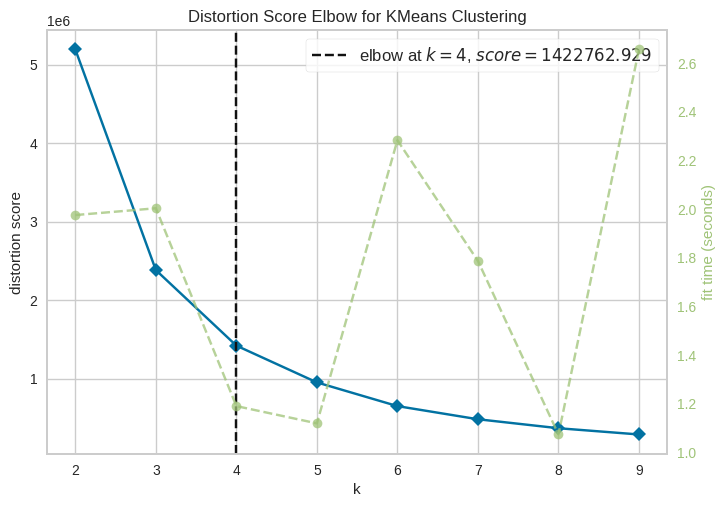

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
#@title Determine the optimal number of clusters K-Means using KElbowVisualizer
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from gensim.models import LdaModel
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(random_state=42)
tfidf = vectorizer.fit_transform(df['clean_text'])

# Extract the ayah_num column as the feature for clustering
X = df['ayah_num'].values.reshape(-1, 1)

# Instantiate the KMeans model
kmeans = KMeans()

# Use the KElbowVisualizer to determine the optimal value of k
visualizer = KElbowVisualizer(kmeans, k=(2, 10))
visualizer.fit(X)
visualizer.show()

# Get the optimal value of k based on the visualizer
optimal_k = visualizer.elbow_value_

# Fit the KMeans model with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)
lda.fit(tfidf)
lda_vecs = lda.transform(tfidf)

clusters = kmeans.labels_

# inisialisasi PCA dengan 2 components
pca = PCA(n_components=2, random_state=42)
# lda_vecs ke pca
pca_vecs = pca.fit_transform(lda_vecs)

# simpan ke dalam x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

#membuat kolom baru untuk clusters, x0, dan x1
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

In [16]:
#@title Determine Best Cluster using Centroid Distance

import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess the text data
text_data = df['clean_text'].tolist()

# Create a vectorizer and transform the text data into a numerical representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text_data)
dataset = list(vectorizer.vocabulary_.keys())

# Convert the sparse matrix X to a dense matrix
X = X.toarray()

# Define the number of clusters (k) for KMeans
k = 4

# Perform KMeans clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

# Function to calculate centroid distance
def centroid_distance(query, centroids):
    if isinstance(query, str):
        query_encoded = vectorizer.transform([query]).toarray()
    else:
        query_encoded = query
    centroid_distances = np.linalg.norm(centroids - query_encoded, axis=1)
    return centroid_distances

# Function to find the best cluster for a query
def find_best_cluster(query, kmeans):
    query_encoded = vectorizer.transform([query]).toarray()
    query_distances = centroid_distance(query_encoded, kmeans.cluster_centers_)
    best_cluster = np.argmin(query_distances)
    return best_cluster

# Example queries
queries = [
    "صادقة", "الثقة", "تسليم", "ذكي", "الأكاذيب",
    "الخيانة", "إخفاء", "غبي", "الأبدية", "واحد",
    "حيا", "أعرف", "الوصية", "يموت", "ضعيف",
    "الحجاب", "أكل", "شراب", "نظيف", "البائس"
]

# Calculate the centroid distances for all queries
centroid_distances = np.zeros((len(queries), k))
for i, query in enumerate(queries):
    centroid_distances[i] = centroid_distance(query, kmeans.cluster_centers_)

# Calculate the average cluster
average_cluster = np.argmin(np.mean(centroid_distances, axis=0))
print(f"Best Cluster: {average_cluster}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Best Cluster: 3


In [17]:
#@title Iterate over the clusters and print the Ayat information

for cluster_num in range(optimal_k):
    cluster_df = df[df['cluster'] == cluster_num]
    cluster_size = len(cluster_df)

    if cluster_size > 1:
        print(f"Cluster {cluster_num}:")

        # Sort the cluster_df by some criteria (e.g., ayah_num) to get the top 5
        sorted_cluster_df = cluster_df.sort_values(by='ayah_num').head(5)

        for _, row in sorted_cluster_df.iterrows():
            verse = row['ayah_txt']
            ayah_num = row['ayah_num']
            surah_name = row['surah_name']

            print("====================================")
            print(verse)
            print(f'Ayat {ayah_num} Surat {surah_name}')
            print()




Cluster 0:
وَإِذْ قُلْنَا لِلْمَلَائِكَةِ اسْجُدُوا لِآدَمَ فَسَجَدُوا إِلَّا إِبْلِيسَ أَبَىٰ وَاسْتَكْبَرَ وَكَانَ مِنَ الْكَافِرِينَ
Ayat 34 Surat Al-Baqara

لِيَكْفُرُوا بِمَا آتَيْنَاهُمْ ۚ فَتَمَتَّعُوا فَسَوْفَ تَعْلَمُونَ
Ayat 34 Surat Ar-Room

إِنَّ اللَّهَ عِنْدَهُ عِلْمُ السَّاعَةِ وَيُنَزِّلُ الْغَيْثَ وَيَعْلَمُ مَا فِي الْأَرْحَامِ ۖ وَمَا تَدْرِي نَفْسٌ مَاذَا تَكْسِبُ غَدًا ۖ وَمَا تَدْرِي نَفْسٌ بِأَيِّ أَرْضٍ تَمُوتُ ۚ إِنَّ اللَّهَ عَلِيمٌ خَبِيرٌ
Ayat 34 Surat Luqman

وَاذْكُرْنَ مَا يُتْلَىٰ فِي بُيُوتِكُنَّ مِنْ آيَاتِ اللَّهِ وَالْحِكْمَةِ ۚ إِنَّ اللَّهَ كَانَ لَطِيفًا خَبِيرًا
Ayat 34 Surat Al-Ahzaab

وَمَا أَرْسَلْنَا فِي قَرْيَةٍ مِنْ نَذِيرٍ إِلَّا قَالَ مُتْرَفُوهَا إِنَّا بِمَا أُرْسِلْتُمْ بِهِ كَافِرُونَ
Ayat 34 Surat Saba

Cluster 1:
وَمِنْهُمْ أُمِّيُّونَ لَا يَعْلَمُونَ الْكِتَابَ إِلَّا أَمَانِيَّ وَإِنْ هُمْ إِلَّا يَظُنُّونَ
Ayat 78 Surat Al-Baqara

لَقَدْ جِئْنَاكُمْ بِالْحَقِّ وَلَٰكِنَّ أَكْثَرَكُمْ لِلْحَقِّ كَارِهُونَ
Ayat 78 Surat Az-Zukhruf


In [18]:
#@title Sample
df.sample(5)

,surah_num,ayah_num,ayah_txt,preprocessed_text,clean_text,surah_name,cluster,x0,x1
529,4,37,الَّذِينَ يَبْخَلُونَ وَيَأْمُرُونَ النَّاسَ بِالْبُخْلِ وَيَكْتُمُونَ مَا آتَاهُمُ اللَّهُ مِنْ فَضْلِهِ ۗ وَأَعْتَدْنَا لِلْكَافِرِينَ عَذَابًا مُهِينًا,الذين يبخلون ويءمرون الناس بالبخل ويكتمون ما ءءتاهم الله من فضله ۗ وءعتدنا للكافرين عذابا مهينا,يبخلون ويءمرون الناس بالبخل ويكتمون ءءتاهم الله فضله ۗ وءعتدنا للكافرين عذابا مهينا,An-Nisaa,0,-0.038616,-0.008016
985,7,32,قُلْ مَنْ حَرَّمَ زِينَةَ اللَّهِ الَّتِي أَخْرَجَ لِعِبَادِهِ وَالطَّيِّبَاتِ مِنَ الرِّزْقِ ۚ قُلْ هِيَ لِلَّذِينَ آمَنُوا فِي الْحَيَاةِ الدُّنْيَا خَالِصَةً يَوْمَ الْقِيَامَةِ ۗ كَذَٰلِكَ نُفَصِّلُ الْآيَاتِ لِقَوْمٍ يَعْلَمُونَ,قل من حرم زينة الله التي ءخرج لعباده والطيبات من الرزق ۚ قل هي للذين ءءمنوا في الحياة الدنيا خالصة يوم القيامة ۗ كذٰلك نفصل الءءيات لقوم يعلمون,قل حرم زينة الله ءخرج لعباده والطيبات الرزق ۚ قل للذين ءءمنوا الحياة الدنيا خالصة يوم القيامة ۗ كذٰلك نفصل الءءيات لقوم يعلمون,Al-A'raaf,2,-0.040020,-0.008298
295,3,3,نَزَّلَ عَلَيْكَ الْكِتَابَ بِالْحَقِّ مُصَدِّقًا لِمَا بَيْنَ يَدَيْهِ وَأَنْزَلَ التَّوْرَاةَ وَالْإِنْجِيلَ,نزل عليك الكتاب بالحق مصدقا لما بين يديه وءنزل التوراة والءنجيل,نزل الكتاب بالحق مصدقا يديه وءنزل التوراة والءنجيل,Aal-i-Imraan,2,-0.162358,-0.445458
1385,10,22,هُوَ الَّذِي يُسَيِّرُكُمْ فِي الْبَرِّ وَالْبَحْرِ ۖ حَتَّىٰ إِذَا كُنْتُمْ فِي الْفُلْكِ وَجَرَيْنَ بِهِمْ بِرِيحٍ طَيِّبَةٍ وَفَرِحُوا بِهَا جَاءَتْهَا رِيحٌ عَاصِفٌ وَجَاءَهُمُ الْمَوْجُ مِنْ كُلِّ مَكَانٍ وَظَنُّوا أَنَّهُمْ أُحِيطَ بِهِمْ ۙ دَعَوُا اللَّهَ مُخْلِصِينَ لَهُ الدِّينَ لَئِنْ أَنْجَيْتَنَا مِنْ هَٰذِهِ لَنَكُونَنَّ مِنَ الشَّاكِرِينَ,هو الذي يسيركم في البر والبحر ۖ حتىٰ ءذا كنتم في الفلك وجرين بهم بريح طيبة وفرحوا بها جاءتها ريح عاصف وجاءهم الموج من كل مكان وظنوا ءنهم ءحيط بهم ۙ دعوا الله مخلصين له الدين لءن ءنجيتنا من هٰذه لنكونن من الشاكرين,يسيركم البر والبحر ۖ حتىٰ ءذا كنتم الفلك وجرين بريح طيبة وفرحوا جاءتها ريح عاصف وجاءهم الموج مكان وظنوا ءنهم ءحيط ۙ دعوا الله مخلصين الدين لءن ءنجيتنا هٰذه لنكونن الشاكرين,Yunus,2,-0.042626,-0.021236
5577,75,27,وَقِيلَ مَنْ ۜ رَاقٍ,وقيل من ۜ راق,وقيل ۜ راق,Al-Qiyaama,2,-0.055463,-0.016593


In [39]:
#@title Get the 10 Top Words

from googletrans import Translator
translator = Translator()

tfidf = vectorizer.fit_transform(df['clean_text'])

def get_top_keywords(n_terms):
    df = pd.DataFrame(tfidf.todense()).groupby(clusters).mean() # mengelompokkan vektor TF-IDF berdasarkan cluster
    terms = vectorizer.get_feature_names_out()
    for i, r in df.iterrows():
        print('\nCluster {}:'.format(i))
        print(', '.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # untuk setiap baris kerangka data, temukan n suku yang memiliki skor tf-idf tertinggi

def get_top_keywords2(n_terms):
    df = pd.DataFrame(tfidf.todense()).groupby(clusters).mean()
    terms = vectorizer.get_feature_names_out()
    for i, r in df.iterrows():
        print(f"\nCluster {i}:")
        translated_keywords = []
        for t in np.argsort(r)[-n_terms:]:
            keyword = terms[t]
            try:
                translated_keyword = translator.translate(keyword, src='arabic', dest='indonesian')
                if translated_keyword is not None and translated_keyword.text is not None:
                    translated_keywords.append(translated_keyword.text)
                else:
                    translated_keywords.append("Translation not available")
            except Exception as e:
                translated_keywords.append("TRANSLATION ERROR")
        print(', '.join(translated_keywords))

print("\nIn Arabic:")
get_top_keywords(10)
print('\n==================================================================')
print("\nIn Indonesian:")
get_top_keywords2(10)



In Arabic:

Cluster 0:
قل, ذا, وءن, على, ءلى, لك, قال, ءلا, ءن, الله

Cluster 1:
قل, وءن, ءلى, ربك, لك, على, قال, ءلا, ءن, الله

Cluster 2:
لك, بسم الله, بسم, الله الرحم, الرحم الرحيم, الرحيم, الرحم, ءلا, ءن, الله

Cluster 3:
على, ءن الله, ءو, لك, فءن, والله, وءن, ءلا, ءن, الله


In Indonesian:

Cluster 0:
Mengatakan, Menjadi, Dan sama, pada, Di dalam, untukmu, Dia berkata, Pernah, Dll., Tuhan

Cluster 1:
Mengatakan, Dan sama, Di dalam, Tuhanmu, untukmu, pada, Dia berkata, Pernah, Dll., Tuhan

Cluster 2:
untukmu, Atas nama tuhan, TRANSLATION ERROR, Tuhan rahim, Rahim yang penuh belas kasihan, Penyayang, rahim, Pernah, Dll., Tuhan

Cluster 3:
pada, Tuhan, Atau, untukmu, Merambat, aku bersumpah, TRANSLATION ERROR, Pernah, Dll., Tuhan


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1754 (\N{ARABIC SMALL HIGH JEEM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1750 (\N{ARABIC SMALL HIGH LIGATURE SAD WITH LAM WITH ALEF MAKSURA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1751 (\N{ARABIC SMALL HIGH LIGATURE QAF WITH LAM WITH ALEF MAKSURA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


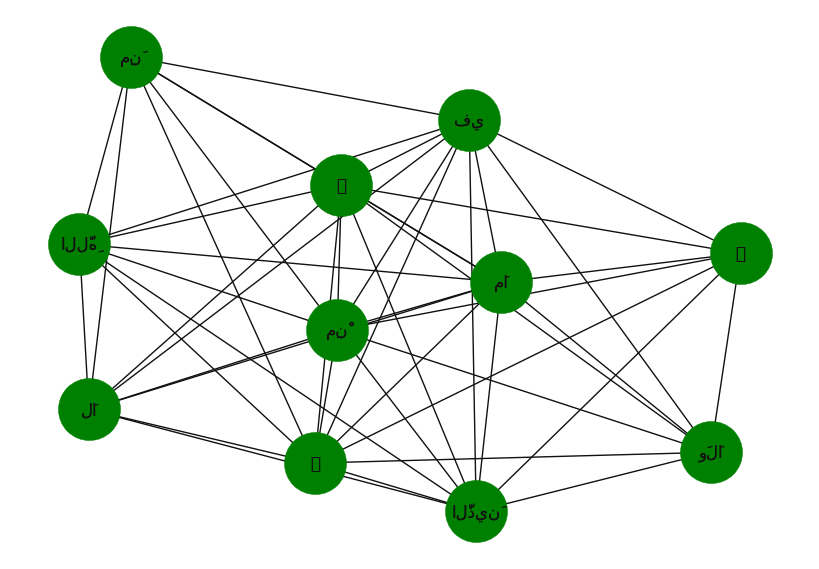

In [20]:
#@title Related Word Graph

import networkx as nx
import matplotlib.pyplot as plt

# Set the font properties for Arabic text
font_properties = {'fontfamily': 'DejaVu Sans', 'script': 'Arabic'}

# Jumlah kata yang ingin ditampilkan untuk setiap cluster
topk = 8

# Menghitung frekuensi kemunculan kata-kata di setiap cluster
word_freq = {}
for i in range(len(df)):
    cluster = df['cluster'][i]
    text = df['ayah_txt'][i]
    for word in text.split():
        if cluster not in word_freq:
            word_freq[cluster] = {}
        if word not in word_freq[cluster]:
            word_freq[cluster][word] = 0
        word_freq[cluster][word] += 1


# Membuat graf
G = nx.Graph()

# Menambahkan edge antara kata-kata yang muncul dalam cluster yang sama
for cluster, word_dict in word_freq.items():
    # Mengambil hanya topk kata dengan frekuensi tertinggi
    topk_words = sorted(word_dict, key=word_dict.get, reverse=True)[:topk]
    for word1 in topk_words:
        for word2 in topk_words:
            if word1 != word2:
                G.add_edge(word1, word2)

# Menentukan posisi kata-kata dalam graf
pos = nx.spring_layout(G)

# Menggambar graf
nx.draw(G, pos, with_labels=True, node_color='green', node_size=2000, font_family='DejaVu Sans')

# Set font properties for node labels
nx.draw_networkx_labels(G, pos, font_family='DejaVu Sans', font_size=12)

# Menampilkan plot
plt.show()

In [21]:
#@title LDA (Latent Dirichlet Allocation)
import nltk
nltk.download('punkt')
import gensim
from gensim import corpora

# Create a dictionary from the corpus
dictionary = corpora.Dictionary(df['clean_text'].apply(word_tokenize))

# Create a document-term matrix
doc_term_matrix = [dictionary.doc2bow(text) for text in df['clean_text'].apply(word_tokenize)]

# Train the LDA model
num_topics = 5  # Specify the number of topics
lda_model = gensim.models.LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Get the topic distributions for each document
topic_distributions = [lda_model.get_document_topics(doc) for doc in doc_term_matrix]

# Assign the topic labels to the dataframe
for topic_num in range(num_topics):
    topic_name = f'topic_{topic_num}'
    df[topic_name] = [topics[topic_num][1] if topic_num < len(topics) else 0 for topics in topic_distributions]

# Function to search for verses in a specific cluster
def search_verses_in_topic(topic_num):
    kalimats_lda = df[df[f'topic_{topic_num}'] > 0.5]['ayah_txt'].values
    return kalimats_lda

#SHOW LDA
def show_best_result3():
    for topic_num in range(num_topics):
        print(f"Cluster {topic_num}:")
        kalimats_lda = search_verses_in_topic(topic_num)

        # Calculate the scores for the verses in the topic
        topic_vectorized = corpus_vectorized[df['cluster'] == topic_num]
        scores = query_vectorized.dot(topic_vectorized.transpose())
        scores_array = scores.toarray()[0]

        # Sort the verses based on scores
        sorted_indices = scores_array.argsort()[::-1]
        for idx in sorted_indices:
            if idx < len(kalimats_lda):
                verse = kalimats_lda[idx]
                score = scores_array[idx]
                if score > 0:
                    row = df[df['ayah_txt'] == verse]
                    surah_num = row['surah_num'].values[0]
                    ayah_num = row['ayah_num'].values[0]
                    surah_name = row['surah_name'].values[0]
                    print(f'Score: {score*100}')
                    print(verse)
                    print(f'Ayat {ayah_num}  Surat {surah_name}')
                    print("====================================")
        print()

#print LDA
# show_best_result3()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# <h1> Similarity Meaning <h1/>

In [22]:
#@title Install depencies

import gensim
import re
import numpy as np
from nltk import ngrams

In [23]:
#@title Preprocessing Arabic Text
import gensim
import re

# Clean/Normalize Arabic Text
def clean_str2(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']

    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)

    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)

    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')

    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])

    #trim
    text = text.strip()

    return text

In [24]:
#@title Download Arabic pre-trained distributed word representation (word embedding)
import gensim
import urllib.request
import zipfile

# Download the pre-trained word embedding model
url = "https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_100_wiki.zip"
filename = "full_grams_cbow_100_wiki.zip"
urllib.request.urlretrieve(url, filename)

# Extract the contents of the downloaded zip file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()

In [25]:
#@title Load the model
t_model = gensim.models.Word2Vec.load("full_grams_cbow_100_wiki.mdl")

In [26]:
#@title Search similiarity meaning of query from the pretained model
first_word = query_asli.split()[0]
print('Query: ', first_word)

token = clean_str2(first_word)

print('\nin Arabic: ')
if token in t_model.wv:
    most_similar = t_model.wv.most_similar(token, topn=10)
    for term, score in most_similar:
        term = clean_str2(term).replace(" ", "_")
        if term != token:
            formatted_score = "{:.5f}".format(score * 100)  # Format the score with 5 decimal places
            formatted_term = term.replace("_", " ")  # Replace underscores with spaces in the term
            print(f"score:{formatted_score}\t word:{formatted_term}")


from googletrans import Translator
translator = Translator()

print('\nin Indonesian: ')
if token in t_model.wv:
    most_similar = t_model.wv.most_similar(token, topn=10)
    for term, score in most_similar:
        term = clean_str2(term).replace(" ", "_")
        if term != token:
            try:
                translated_term = translator.translate(term, src='arabic', dest='indonesian')
                if translated_term is not None and translated_term.text is not None:
                    formatted_score = "{:.5f}".format(score * 100)  # Format the score with 5 decimal places
                    formatted_term = term.replace("_", " ")  # Replace underscores with spaces in the term
                    translated_text = translated_term.text
                    print(f"score: {formatted_score}\t word: {translated_text}")
                else:
                    print(f"score: {formatted_score}\t word: Translation not available")
            except Exception as e:
                print(f"score: {formatted_score}\t word: Translation error: {str(e)}")





Query:  كذب

in Arabic: 
score:79.37731	 word:يكذب
score:77.87850	 word:انكر
score:74.94476	 word:ندم
score:74.55535	 word:واجاب
score:73.26359	 word:لم يصدق
score:72.91319	 word:باطل
score:72.76035	 word:كذبه
score:71.74166	 word:بريء
score:71.34794	 word:صدق
score:70.72480	 word:زعمه

in Indonesian: 
score: 79.37731	 word: Dia berbohong
score: 79.37731	 word: Translation error: The read operation timed out
score: 79.37731	 word: Translation error: The read operation timed out
score: 79.37731	 word: Translation error: The read operation timed out
score: 73.26359	 word: Dia tidak percaya
score: 72.91319	 word: ruang kosong
score: 72.76035	 word: kebohongan
score: 71.74166	 word: Tidak bersalah
score: 71.74166	 word: Translation error: The read operation timed out
score: 70.72480	 word: Dugaan


# **<h1>Searching Method<h1/>**

In [38]:
#@title Vector Space Model

from sklearn.feature_extraction.text import TfidfVectorizer

# Apply the TfidfVectorizer to the corpus
corpus = df["clean_text"]
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
corpus_vectorized = vectorizer.fit_transform(corpus)
print(corpus_vectorized.shape)

# vector
def show_best_result1(df_quran, scores_array, top_n=20):
    sorted_indices = scores_array.argsort()[::-1]
    for position, idx in enumerate(sorted_indices[:top_n]):
        row = df_quran.iloc[idx]
        scoreValue = scores_array[idx]
        ayah = row['ayah_txt']
        ayah_num = row['ayah_num']
        surah_name = row['surah_name']
        score = scores_array[idx]
        if score > 0:
            print(f'Score: {score*100}')
            print(ayah)
            print(f'Ayat {ayah_num}  Surat {surah_name}')
            print("====================================")

# VSM Model
def vsm_model(query_asli, vectorizer, corpus_vectorized, df):
    query_asli = preprocess_text(query_asli)  # Clean and normalize the query text
    query_vectorized = vectorizer.transform([query_asli])  # Vector representation using TF-IDF

    for cluster in range(4):
        cluster_indices = df[df['cluster'] == cluster].index
        cluster_vectorized = corpus_vectorized[cluster_indices]
        cluster_scores = query_vectorized.dot(cluster_vectorized.transpose())
        cluster_scores_array = cluster_scores.toarray()[0]
        print(f"Cluster: {cluster}")
        show_best_result1(df.iloc[cluster_indices], cluster_scores_array)

# Example usage
vsm_model(query_asli, vectorizer, corpus_vectorized, df)


(6236, 52649)
Cluster: 0
Score: 22.54665337450419
إِنَّا قَدْ أُوحِيَ إِلَيْنَا أَنَّ الْعَذَابَ عَلَىٰ مَنْ كَذَّبَ وَتَوَلَّىٰ
Ayat 48  Surat Taa-Haa
Score: 18.58191174715193
وَمَنْ أَظْلَمُ مِمَّنِ افْتَرَىٰ عَلَى اللَّهِ كَذِبًا أَوْ كَذَّبَ بِالْحَقِّ لَمَّا جَاءَهُ ۚ أَلَيْسَ فِي جَهَنَّمَ مَثْوًى لِلْكَافِرِينَ
Ayat 68  Surat Al-Ankaboot
Score: 16.903617842123637
بَلْ كَذَّبُوا بِمَا لَمْ يُحِيطُوا بِعِلْمِهِ وَلَمَّا يَأْتِهِمْ تَأْوِيلُهُ ۚ كَذَٰلِكَ كَذَّبَ الَّذِينَ مِنْ قَبْلِهِمْ ۖ فَانْظُرْ كَيْفَ كَانَ عَاقِبَةُ الظَّالِمِينَ
Ayat 39  Surat Yunus
Score: 12.156534563330082
وَمَا مَنَعَنَا أَنْ نُرْسِلَ بِالْآيَاتِ إِلَّا أَنْ كَذَّبَ بِهَا الْأَوَّلُونَ ۚ وَآتَيْنَا ثَمُودَ النَّاقَةَ مُبْصِرَةً فَظَلَمُوا بِهَا ۚ وَمَا نُرْسِلُ بِالْآيَاتِ إِلَّا تَخْوِيفًا
Ayat 59  Surat Al-Israa
Score: 11.374002034173438
فَمَنْ أَظْلَمُ مِمَّنِ افْتَرَىٰ عَلَى اللَّهِ كَذِبًا أَوْ كَذَّبَ بِآيَاتِهِ ۚ أُولَٰئِكَ يَنَالُهُمْ نَصِيبُهُمْ مِنَ الْكِتَابِ ۖ حَتَّىٰ إِذَا جَاءَتْهُمْ رُسُلُ

In [28]:
#@title Fuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Function to search for kalimats in a specific cluster
def search_verses_in_cluster(cluster, query_asli):
    kalimats_KM = df[df['cluster'] == cluster]['ayah_txt'].values

    # Perform fuzzy matching for each verse in the cluster
    matches = process.extract(query_asli, kalimats_KM, scorer=fuzz.ratio, limit=10)

    # Sort the matches by score in descending order
    matches = sorted(matches, key=lambda x: x[1], reverse=True)

    return matches

def search_query_fuzzykmeans(query_asli):
    for cluster in range(4):
        print(f"\n\nCluster {cluster}:\n")
        matches = search_verses_in_cluster(cluster, query_asli)

        # Display the fuzzy matching results
        for match in matches:
            verse = match[0]
            score = match[1]
            if score > 0:  # Adjust the threshold as per your preference
                row = df[df['ayah_txt'] == verse]
                surah_num = row['surah_num'].values[0]
                ayah_num = row['ayah_num'].values[0]
                surah_name = row['surah_name'].values[0]
                print(f'Score: {score}')
                print(verse)
                print(f'Ayat {ayah_num}  Surat {surah_name}')
                print("====================================")
        print()

search_query_fuzzykmeans(query_asli)



Cluster 0:

Score: 19
نَذِيرًا لِلْبَشَرِ
Ayat 36  Surat Al-Muddaththir
Score: 17
وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ
Ayat 15  Surat Al-Mursalaat
Score: 17
وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ
Ayat 15  Surat Al-Mursalaat
Score: 17
وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ
Ayat 15  Surat Al-Mursalaat
Score: 17
وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ
Ayat 15  Surat Al-Mursalaat
Score: 17
وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ
Ayat 15  Surat Al-Mursalaat
Score: 17
وَيْلٌ يَوْمَئِذٍ لِلْمُكَذِّبِينَ
Ayat 15  Surat Al-Mursalaat
Score: 16
وَكُنَّا نُكَذِّبُ بِيَوْمِ الدِّينِ
Ayat 46  Surat Al-Muddaththir
Score: 15
قَالَ رَبِّ انْصُرْنِي بِمَا كَذَّبُونِ
Ayat 26  Surat Al-Muminoon
Score: 15
كَلَّا إِنَّهُ تَذْكِرَةٌ
Ayat 54  Surat Al-Muddaththir



Cluster 1:



/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Score: 19
كَذَّبَتْ عَادٌ الْمُرْسَلِينَ
Ayat 123  Surat Ash-Shu'araa
Score: 18
كَذَّبَتْ ثَمُودُ الْمُرْسَلِينَ
Ayat 141  Surat Ash-Shu'araa
Score: 17
فِي كِتَابٍ مَكْنُونٍ
Ayat 78  Surat Al-Waaqia
Score: 16
قَالَ رَبِّ إِنَّ قَوْمِي كَذَّبُونِ
Ayat 117  Surat Ash-Shu'araa
Score: 15
كَذَّبَتْ قَوْمُ نُوحٍ الْمُرْسَلِينَ
Ayat 105  Surat Ash-Shu'araa
Score: 15
فَكَذَّبُوهُ فَإِنَّهُمْ لَمُحْضَرُونَ
Ayat 127  Surat As-Saaffaat
Score: 14
وَمَا نَحْنُ بِمُعَذَّبِينَ
Ayat 138  Surat Ash-Shu'araa
Score: 12
كَذَٰلِكَ وَقَدْ أَحَطْنَا بِمَا لَدَيْهِ خُبْرًا
Ayat 91  Surat Al-Kahf
Score: 12
إِنِّي أَخَافُ عَلَيْكُمْ عَذَابَ يَوْمٍ عَظِيمٍ
Ayat 135  Surat Ash-Shu'araa
Score: 12
وَفَدَيْنَاهُ بِذِبْحٍ عَظِيمٍ
Ayat 107  Surat As-Saaffaat



Cluster 2:

Score: 30
فَكَذَّبَ وَعَصَىٰ
Ayat 21  Surat An-Naazi'aat
Score: 25
فَكُّ رَقَبَةٍ
Ayat 13  Surat Al-Balad
Score: 24
وَكَذَّبَ بِالْحُسْنَىٰ
Ayat 9  Surat Al-Lail
Score: 22
كِرَامٍ بَرَرَةٍ
Ayat 16  Surat Abasa
Score: 21
وَمَاءٍ مَسْكُوبٍ
Ayat 31  Su

In [29]:
#@title Okopi BM25

from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Preprocess and tokenize the corpus
corpus = df['ayah_txt'].apply(preprocess_text).apply(word_tokenize).tolist()
bm25 = BM25Okapi(corpus)  # Initialize BM25Okapi with the corpus

def search_query_bm25(query_asli, cluster):
    # Preprocess and tokenize the query
    query_asli = preprocess_text(query_asli)
    query_tokens = word_tokenize(query_asli)

    # Filter documents within the specified cluster
    cluster_corpus = [corpus[i] for i in range(len(corpus)) if df['cluster'][i] == cluster]

    # Initialize a new BM25Okapi object with the cluster corpus
    bm25_cluster = BM25Okapi(cluster_corpus)

    # Get the scores for the query within the cluster
    doc_scores = bm25_cluster.get_scores(query_tokens)
    top_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)

    # Print the verses with non-zero scores
    for idx in top_indices:
        verse = df[df['cluster'] == cluster]['ayah_txt'].iloc[idx]
        ayah_num = df[df['cluster'] == cluster]['ayah_num'].iloc[idx]
        surah_name = df[df['cluster'] == cluster]['surah_name'].iloc[idx]
        score = doc_scores[idx] * 10
        if score > 0:
            print(f'Score: {score}')
            print(verse)
            print(f'Ayat {ayah_num} Surat {surah_name}')
            print("====================================")

# Function to search for the query in all clusters
def search_query_in_all_clusters(query_asli):
    # Iterate over each cluster
    for cluster in range(4):  # Assuming you have 4 clusters
        print(f"\n\nCluster {cluster}:\n")
        search_query_bm25(query_asli, cluster)

# Call the function to search the query in all clusters
search_query_in_all_clusters(query_asli)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




Cluster 0:

Score: 65.66503641501002
إِنَّا قَدْ أُوحِيَ إِلَيْنَا أَنَّ الْعَذَابَ عَلَىٰ مَنْ كَذَّبَ وَتَوَلَّىٰ
Ayat 48 Surat Taa-Haa
Score: 50.27750091148093
وَمَنْ أَظْلَمُ مِمَّنِ افْتَرَىٰ عَلَى اللَّهِ كَذِبًا أَوْ كَذَّبَ بِالْحَقِّ لَمَّا جَاءَهُ ۚ أَلَيْسَ فِي جَهَنَّمَ مَثْوًى لِلْكَافِرِينَ
Ayat 68 Surat Al-Ankaboot
Score: 46.21624116123711
بَلْ كَذَّبُوا بِمَا لَمْ يُحِيطُوا بِعِلْمِهِ وَلَمَّا يَأْتِهِمْ تَأْوِيلُهُ ۚ كَذَٰلِكَ كَذَّبَ الَّذِينَ مِنْ قَبْلِهِمْ ۖ فَانْظُرْ كَيْفَ كَانَ عَاقِبَةُ الظَّالِمِينَ
Ayat 39 Surat Yunus
Score: 43.85461511889307
وَمَا مَنَعَنَا أَنْ نُرْسِلَ بِالْآيَاتِ إِلَّا أَنْ كَذَّبَ بِهَا الْأَوَّلُونَ ۚ وَآتَيْنَا ثَمُودَ النَّاقَةَ مُبْصِرَةً فَظَلَمُوا بِهَا ۚ وَمَا نُرْسِلُ بِالْآيَاتِ إِلَّا تَخْوِيفًا
Ayat 59 Surat Al-Israa
Score: 30.574650125288294
فَمَنْ أَظْلَمُ مِمَّنِ افْتَرَىٰ عَلَى اللَّهِ كَذِبًا أَوْ كَذَّبَ بِآيَاتِهِ ۚ أُولَٰئِكَ يَنَالُهُمْ نَصِيبُهُمْ مِنَ الْكِتَابِ ۖ حَتَّىٰ إِذَا جَاءَتْهُمْ رُسُلُنَا يَتَوَفَّوْنَ

In [30]:
#@title Determine best searching method

from sklearn.feature_extraction.text import TfidfVectorizer
from fuzzywuzzy import fuzz, process
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

# Apply the TfidfVectorizer to the corpus
corpus = df["clean_text"]
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
corpus_vectorized = vectorizer.fit_transform(corpus)

# VSM Model
def vsm_model(query_asli, vectorizer, corpus_vectorized, df):
    query_asli = preprocess_text(query_asli)  # Clean and normalize the query text
    query_vectorized = vectorizer.transform([query_asli])  # Vector representation using TF-IDF

    scores = []
    for cluster in range(4):
        cluster_indices = df[df['cluster'] == cluster].index
        cluster_vectorized = corpus_vectorized[cluster_indices]
        cluster_scores = query_vectorized.dot(cluster_vectorized.transpose())
        cluster_scores_array = cluster_scores.toarray()[0]
        scores.extend(cluster_scores_array)

    return scores

# Fuzzy Model
def search_verses_in_cluster(cluster, query_asli):
    kalimats_KM = df[df['cluster'] == cluster]['ayah_txt'].values

    # Perform fuzzy matching for each verse in the cluster
    matches = process.extract(query_asli, kalimats_KM, scorer=fuzz.ratio, limit=10)

    # Sort the matches by score in descending order
    matches = sorted(matches, key=lambda x: x[1], reverse=True)

    return matches

def search_query_fuzzykmeans(query_asli):
    scores = []
    for cluster in range(4):
        matches = search_verses_in_cluster(cluster, query_asli)

        for match in matches:
            score = match[1]
            scores.append(score)

    return scores

# Okopi BM25
# Preprocess and tokenize the corpus
corpus = df['ayah_txt'].apply(preprocess_text).apply(word_tokenize).tolist()
bm25 = BM25Okapi(corpus)  # Initialize BM25Okapi with the corpus

def search_query_bm25(query_asli, cluster):
    query_asli = preprocess_text(query_asli)
    query_tokens = word_tokenize(query_asli)

    cluster_corpus = [corpus[i] for i in range(len(corpus)) if df['cluster'][i] == cluster]
    bm25_cluster = BM25Okapi(cluster_corpus)

    doc_scores = bm25_cluster.get_scores(query_tokens)
    scores = [score * 10 for score in doc_scores]

    return scores

def search_query_in_all_clusters(query_asli):
    scores = []
    for cluster in range(4):
        scores.extend(search_query_bm25(query_asli, cluster))

    return scores

# Query list
queries = [
    "كَذِبٌ",
    "فإن",
    "لا",
    "والله",
    "الله"
]

# Perform searches for each query and collect the scores
vsm_scores = []
fuzzy_scores = []
bm25_scores = []

for query in queries:
    vsm_scores.extend(vsm_model(query, vectorizer, corpus_vectorized, df))
    fuzzy_scores.extend(search_query_fuzzykmeans(query))
    bm25_scores.extend(search_query_in_all_clusters(query))

# Sort scores in descending order
vsm_scores.sort(reverse=True)
fuzzy_scores.sort(reverse=True)
bm25_scores.sort(reverse=True)

# Calculate average scores from the top 5 highest scores for each method
vsm_avg_score = sum(vsm_scores[:5]) / 5
fuzzy_avg_score = sum(fuzzy_scores[:5]) / 5
bm25_avg_score = sum(bm25_scores[:5]) / 5

# Print average scores
print("Average Scores (from top 5 highest scores):")
print("VSM:", vsm_avg_score*100)
print("Fuzzy:", fuzzy_avg_score)
print("BM25:", bm25_avg_score)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Average Scores (from top 5 highest scores):
VSM: 41.00074789289729
Fuzzy: 41.4
BM25: 78.99856208231566


# <h1> Searching Method with Similarity Word (Word Embedding) <h1/>

In [31]:
#@title Merge all result from similiar word and add the real query
merged_words = []

if token in t_model.wv:
    most_similar = t_model.wv.most_similar(token, topn=10)
    for term, score in most_similar:
        term = clean_str2(term).replace(" ", "_")
        if term != token:
            formatted_term = term.replace("_", " ")  # Replace underscores with spaces in the term
            merged_words.append(formatted_term)

merged_result = ', '.join(merged_words)

#Add the query_asli
merged_words.append(query_asli)


query_sw = f"{merged_result}"
query_sw = clean_str2(query_sw).replace(",", " ")
print(query_sw)

يكذب  انكر  ندم  واجاب  لم يصدق  باطل  كذبه  بريء  صدق  زعمه


In [35]:
#@title Vector Space Model with Word Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply the TfidfVectorizer to the corpus
corpus = df["clean_text"]
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
corpus_vectorized = vectorizer.fit_transform(corpus)
print(corpus_vectorized.shape)

# vector
def show_best_result1(df_quran, scores_array, top_n=20):
    sorted_indices = scores_array.argsort()[::-1]
    for position, idx in enumerate(sorted_indices[:top_n]):
        row = df_quran.iloc[idx]
        scoreValue = scores_array[idx]
        ayah = row['ayah_txt']
        ayah_num = row['ayah_num']
        surah_name = row['surah_name']
        score = scores_array[idx]
        if score > 0:
            print(f'Score: {score*100}')
            print(ayah)
            print(f'Ayat {ayah_num}  Surat {surah_name}')
            print("====================================")

# VSM Model
def vsm_model(query_sw, vectorizer, corpus_vectorized, df):
    query_sw = preprocess_text(query_sw)  # Clean and normalize the query text
    query_vectorized = vectorizer.transform([query_sw])  # Vector representation using TF-IDF

    for cluster in range(4):
        cluster_indices = df[df['cluster'] == cluster].index
        cluster_vectorized = corpus_vectorized[cluster_indices]
        cluster_scores = query_vectorized.dot(cluster_vectorized.transpose())
        cluster_scores_array = cluster_scores.toarray()[0]
        print(f"Cluster: {cluster}")
        show_best_result1(df.iloc[cluster_indices], cluster_scores_array)

# Example usage
vsm_model(query_sw, vectorizer, corpus_vectorized, df)




(6236, 52649)
Cluster: 0
Score: 19.41734278634146
هَٰذِهِ جَهَنَّمُ الَّتِي يُكَذِّبُ بِهَا الْمُجْرِمُونَ
Ayat 43  Surat Ar-Rahmaan
Score: 14.577354626218758
فِي مَقْعَدِ صِدْقٍ عِنْدَ مَلِيكٍ مُقْتَدِرٍ
Ayat 55  Surat Al-Qamar
Score: 13.890198059640207
فَذَرْنِي وَمَنْ يُكَذِّبُ بِهَٰذَا الْحَدِيثِ ۖ سَنَسْتَدْرِجُهُمْ مِنْ حَيْثُ لَا يَعْلَمُونَ
Ayat 44  Surat Al-Qalam
Score: 12.380828812127506
وَوَهَبْنَا لَهُمْ مِنْ رَحْمَتِنَا وَجَعَلْنَا لَهُمْ لِسَانَ صِدْقٍ عَلِيًّا
Ayat 50  Surat Maryam
Score: 9.812646504759664
أَمْ يَقُولُونَ افْتَرَاهُ ۖ قُلْ إِنِ افْتَرَيْتُهُ فَعَلَيَّ إِجْرَامِي وَأَنَا بَرِيءٌ مِمَّا تُجْرِمُونَ
Ayat 35  Surat Hud
Score: 8.95362103686706
وَإِنْ كَذَّبُوكَ فَقُلْ لِي عَمَلِي وَلَكُمْ عَمَلُكُمْ ۖ أَنْتُمْ بَرِيئُونَ مِمَّا أَعْمَلُ وَأَنَا بَرِيءٌ مِمَّا تَعْمَلُونَ
Ayat 41  Surat Yunus
Score: 8.497386587418493
إِنْ نَقُولُ إِلَّا اعْتَرَاكَ بَعْضُ آلِهَتِنَا بِسُوءٍ ۗ قَالَ إِنِّي أُشْهِدُ اللَّهَ وَاشْهَدُوا أَنِّي بَرِيءٌ مِمَّا تُشْرِكُونَ
Ayat 54  S

In [36]:
#@title Fuzzy with Word Embedding
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Function to search for kalimats in a specific cluster
def search_verses_in_cluster(cluster, query_sw):
    kalimats_KM = df[df['cluster'] == cluster]['ayah_txt'].values

    # Perform fuzzy matching for each verse in the cluster
    matches = process.extract(query_sw, kalimats_KM, scorer=fuzz.ratio, limit=10)

    # Sort the matches by score in descending order
    matches = sorted(matches, key=lambda x: x[1], reverse=True)

    return matches

def search_query_fuzzykmeans(query_sw):
    for cluster in range(4):
        print(f"\n\nCluster {cluster}:\n")
        matches = search_verses_in_cluster(cluster, query_sw)

        # Display the fuzzy matching results
        for match in matches:
            verse = match[0]
            score = match[1]
            if score > 0:  # Adjust the threshold as per your preference
                row = df[df['ayah_txt'] == verse]
                surah_num = row['surah_num'].values[0]
                ayah_num = row['ayah_num'].values[0]
                surah_name = row['surah_name'].values[0]
                print(f'Score: {score}')
                print(verse)
                print(f'Ayat {ayah_num}  Surat {surah_name}')
                print("====================================")
        print()

search_query_fuzzykmeans(query_sw)



Cluster 0:

Score: 49
لَهَا سَبْعَةُ أَبْوَابٍ لِكُلِّ بَابٍ مِنْهُمْ جُزْءٌ مَقْسُومٌ
Ayat 44  Surat Al-Hijr
Score: 47
كَذَٰلِكَ يُؤْفَكُ الَّذِينَ كَانُوا بِآيَاتِ اللَّهِ يَجْحَدُونَ
Ayat 63  Surat Ghafir
Score: 45
بَلِ اللَّهَ فَاعْبُدْ وَكُنْ مِنَ الشَّاكِرِينَ
Ayat 66  Surat Az-Zumar
Score: 45
فَمَا مِنْكُمْ مِنْ أَحَدٍ عَنْهُ حَاجِزِينَ
Ayat 47  Surat Al-Haaqqa
Score: 44
قُلْ جَاءَ الْحَقُّ وَمَا يُبْدِئُ الْبَاطِلُ وَمَا يُعِيدُ
Ayat 49  Surat Saba
Score: 43
وَاذْكُرْ فِي الْكِتَابِ إِدْرِيسَ ۚ إِنَّهُ كَانَ صِدِّيقًا نَبِيًّا
Ayat 56  Surat Maryam
Score: 43
هَٰذَا ذِكْرٌ ۚ وَإِنَّ لِلْمُتَّقِينَ لَحُسْنَ مَآبٍ
Ayat 49  Surat Saad
Score: 43
حُورٌ مَقْصُورَاتٌ فِي الْخِيَامِ
Ayat 72  Surat Ar-Rahmaan
Score: 43
فَبِأَيِّ حَدِيثٍ بَعْدَهُ يُؤْمِنُونَ
Ayat 50  Surat Al-Mursalaat
Score: 42
ذَٰلِكَ الْفَضْلُ مِنَ اللَّهِ ۚ وَكَفَىٰ بِاللَّهِ عَلِيمًا
Ayat 70  Surat An-Nisaa



Cluster 1:

Score: 44
وَلَقَدْ نَعْلَمُ أَنَّكَ يَضِيقُ صَدْرُكَ بِمَا يَقُولُونَ
Ayat 97  Surat Al-Hijr
S

In [37]:
#@title Okopi BM25 with Word Embedding

from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Preprocess and tokenize the corpus
corpus = df['ayah_txt'].apply(preprocess_text).apply(word_tokenize).tolist()
bm25 = BM25Okapi(corpus)  # Initialize BM25Okapi with the corpus

def search_query_bm25(query_sw, cluster):
    # Preprocess and tokenize the query
    query_sw = preprocess_text(query_sw)
    query_tokens = word_tokenize(query_sw)

    # Filter documents within the specified cluster
    cluster_corpus = [corpus[i] for i in range(len(corpus)) if df['cluster'][i] == cluster]

    # Initialize a new BM25Okapi object with the cluster corpus
    bm25_cluster = BM25Okapi(cluster_corpus)

    # Get the scores for the query within the cluster
    doc_scores = bm25_cluster.get_scores(query_tokens)
    top_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)

    # Print the verses with non-zero scores
    for idx in top_indices:
        verse = df[df['cluster'] == cluster]['ayah_txt'].iloc[idx]
        ayah_num = df[df['cluster'] == cluster]['ayah_num'].iloc[idx]
        surah_name = df[df['cluster'] == cluster]['surah_name'].iloc[idx]
        score = doc_scores[idx] * 10
        if score > 0:
            print(f'Score: {score}')
            print(verse)
            print(f'Ayat {ayah_num} Surat {surah_name}')
            print("====================================")

# Function to search for the query in all clusters
def search_query_in_all_clusters(query_sw):
    # Iterate over each cluster
    cluster = average_cluster
    print(f"\n\nCluster {cluster}:\n")
    search_query_bm25(query_sw, cluster)

# Call the function to search the query in all clusters
search_query_in_all_clusters(query_sw)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




Cluster 3:

Score: 78.44599492922944
فَإِنْ عَصَوْكَ فَقُلْ إِنِّي بَرِيءٌ مِمَّا تَعْمَلُونَ
Ayat 216 Surat Ash-Shu'araa
Score: 38.23009021779872
قَالُوا لَئِنْ لَمْ تَنْتَهِ يَا لُوطُ لَتَكُونَنَّ مِنَ الْمُخْرَجِينَ
Ayat 167 Surat Ash-Shu'araa
Score: 34.91654365106237
إِنَّ الَّذِينَ كَفَرُوا وَظَلَمُوا لَمْ يَكُنِ اللَّهُ لِيَغْفِرَ لَهُمْ وَلَا لِيَهْدِيَهُمْ طَرِيقًا
Ayat 168 Surat An-Nisaa
Score: 32.131578195646426
وَرُسُلًا قَدْ قَصَصْنَاهُمْ عَلَيْكَ مِنْ قَبْلُ وَرُسُلًا لَمْ نَقْصُصْهُمْ عَلَيْكَ ۚ وَكَلَّمَ اللَّهُ مُوسَىٰ تَكْلِيمًا
Ayat 164 Surat An-Nisaa
Score: 31.299424281543743
فَإِنْ خِفْتُمْ فَرِجَالًا أَوْ رُكْبَانًا ۖ فَإِذَا أَمِنْتُمْ فَاذْكُرُوا اللَّهَ كَمَا عَلَّمَكُمْ مَا لَمْ تَكُونُوا تَعْلَمُونَ
Ayat 239 Surat Al-Baqara
Score: 31.299424281543743
فَانْقَلَبُوا بِنِعْمَةٍ مِنَ اللَّهِ وَفَضْلٍ لَمْ يَمْسَسْهُمْ سُوءٌ وَاتَّبَعُوا رِضْوَانَ اللَّهِ ۗ وَاللَّهُ ذُو فَضْلٍ عَظِيمٍ
Ayat 174 Surat Aal-i-Imraan
Score: 30.509285035831816
كَمَا أَرْسَلْنَا فِيكُمْ